In [1]:
import torch

In [2]:
!pip3 freeze | grep torch

torch==1.6.0
torchsummary==1.5.1
torchvision==0.7.0


In [3]:
import torch.utils.data as data
from torchvision import transforms, datasets

In [4]:
def get_celeba(root, split, download=True):
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
#         transforms.Normalize(0, 1),
    ])
    return datasets.CelebA(root, split=split, transform=transform,
        download=download)

def get_data():
    dataset_train = get_celeba('~/data', 'train',)
    dataset_test = get_celeba('~/data', 'test')
    print('train', len(dataset_train))
    print('test', len(dataset_test))
    return dataset_train, dataset_test

dataset_train, dataset_test = get_data()

Files already downloaded and verified
Files already downloaded and verified
train 162770
test 19962


In [5]:
batch_size = 32
workers = 4
train_data = data.DataLoader(dataset_train, batch_size=batch_size,
                             num_workers=workers, drop_last=True, shuffle=True)
test_data = data.DataLoader(dataset_test, batch_size=batch_size,
                             num_workers=workers, drop_last=True)

In [6]:
import matplotlib.pyplot as plt

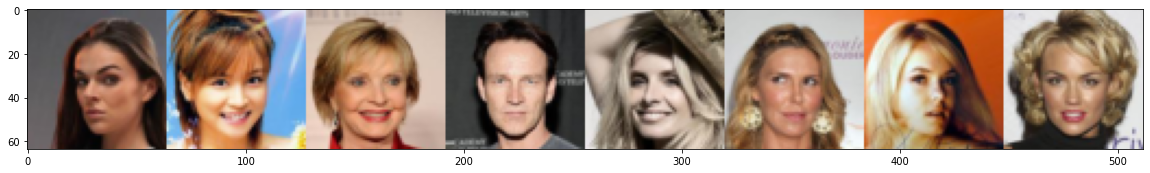

<Figure size 432x288 with 0 Axes>

In [7]:
def plot_imgs(img, save_file=False, file_name='out'):
    img = img.permute(1, 2, 0, 3).reshape(3, 64, -1)
    img = (img + 1) / 2
    plt.figure(figsize=(20,10))
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    plt.savefig(file_name)

plot_imgs(next(iter(train_data))[0][:8])

In [8]:
import torch
from torch import nn
import torch.nn.functional as F

latent_dim = 100
g_hidden = 128 # hidden dim of generator
d_hidden = 128 # hidden dim of discriminator

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, g_hidden * 8,
                kernel_size=4, stride=1, padding=0, bias=False),
#             nn.BatchNorm2d(g_hidden * 8),
            nn.SELU(inplace=True),
            # shape is (g_hidden*8, 4, 4),

            nn.ConvTranspose2d(g_hidden * 8, g_hidden * 4,
                kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(g_hidden * 4),
            nn.SELU(inplace=True),
            # shape is (g_hidden*4, 8, 8),

            nn.ConvTranspose2d(g_hidden * 4, g_hidden * 2,
                kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(g_hidden * 2),
            nn.SELU(inplace=True),
            # shape is (g_hidden*2, 16, 16),

            nn.ConvTranspose2d(g_hidden * 2, g_hidden,
                kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(g_hidden),
            nn.SELU(inplace=True),
            # shape is (g_hidden, 32, 32),

            nn.ConvTranspose2d(g_hidden, 3,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # shape is (3, 64, 64),
        )

    def forward(self, x):
        output = self.main(x)
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, d_hidden,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.SELU(inplace=True),
            # shape is (d_hidden, 32, 32),

            nn.Conv2d(d_hidden, d_hidden * 2,
                kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(d_hidden * 2),
            nn.SELU(inplace=True),
            # shape is (d_hidden * 2, 16, 16),

            nn.Conv2d(d_hidden * 2, d_hidden * 4,
                kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(d_hidden * 4),
            nn.SELU(inplace=True),
            # shape is (d_hidden * 4, 8, 8),

            nn.Conv2d(d_hidden * 4, d_hidden * 8,
                kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(d_hidden * 8),
            nn.SELU(inplace=True),
            # shape is (d_hidden * 8, 4, 4),

            nn.Conv2d(d_hidden * 8, 1,
                kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # shape is (1, 1, 1)
        )

    def forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

def weights_init(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)

#         w_std = torch.sqrt(1. / torch.prod(torch.tensor(m.weight.shape[1:], dtype=torch.float)))
#         w_std = 0.01
#         print('w_std', w_std)
#         torch.nn.init.normal_(m.weight, 0.0, w_std)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [9]:
def test_model():
    # test whether our model works fine
    net_d = Discriminator()
    net_g = Generator()

    x = torch.rand(16, latent_dim, 1, 1)

    out = net_g(x)
    print(out.shape)
    out2 = net_d(out)
    print(out2.shape)
test_model()

torch.Size([16, 3, 64, 64])
torch.Size([16])


In [10]:
# setting
lr = 2e-4
beta1 = 0.5
start_epoch = 1
max_epoch = 5

import os
os.makedirs('ckpts', exist_ok=True)
os.makedirs('out_imgs', exist_ok=True)

In [11]:
device = torch.device('cuda:2')

net_g = Generator().to(device)
net_g.apply(weights_init)
# print(net_g)

net_d = Discriminator().to(device)
net_d.apply(weights_init)
# print(net_g)

criterion = nn.BCELoss()

optim_d = torch.optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.99))
optim_g = torch.optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.99))
# optim_d = torch.optim.SGD(net_d.parameters(), lr=lr, momentum=0.9)
# optim_g = torch.optim.SGD(net_g.parameters(), lr=lr, momentum=0.9)

In [12]:
# label setting
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
real_label = torch.ones(batch_size, device=device).float()
fake_label = torch.zeros(batch_size, device=device).float()

[1/10 - 0/5086] Loss_D: 2.0608 Loss_G: 0.4062   D(G(z)): 0.3070 / 0.5221 / 0.6698
[1/10 - 508/5086] Loss_D: 1.1554 Loss_G: 2.9030   D(G(z)): 0.6245 / 0.2862 / 0.1155
[1/10 - 1016/5086] Loss_D: 1.3756 Loss_G: 1.1829   D(G(z)): 0.6181 / 0.5459 / 0.3503
[1/10 - 1524/5086] Loss_D: 1.2597 Loss_G: 0.8775   D(G(z)): 0.4766 / 0.3597 / 0.4508
[1/10 - 2032/5086] Loss_D: 1.6977 Loss_G: 1.0347   D(G(z)): 0.3148 / 0.3352 / 0.3964
[1/10 - 2540/5086] Loss_D: 1.1793 Loss_G: 1.1692   D(G(z)): 0.5476 / 0.3973 / 0.3340
[1/10 - 3048/5086] Loss_D: 1.5027 Loss_G: 1.3160   D(G(z)): 0.6175 / 0.6149 / 0.2755
[1/10 - 3556/5086] Loss_D: 1.3286 Loss_G: 0.8873   D(G(z)): 0.5414 / 0.5001 / 0.4163
[1/10 - 4064/5086] Loss_D: 1.4498 Loss_G: 0.5518   D(G(z)): 0.3789 / 0.3157 / 0.6303
[1/10 - 4572/5086] Loss_D: 1.1974 Loss_G: 0.9070   D(G(z)): 0.4783 / 0.2394 / 0.4295
[1/10 - 5080/5086] Loss_D: 1.2559 Loss_G: 2.7872   D(G(z)): 0.6895 / 0.5200 / 0.0968


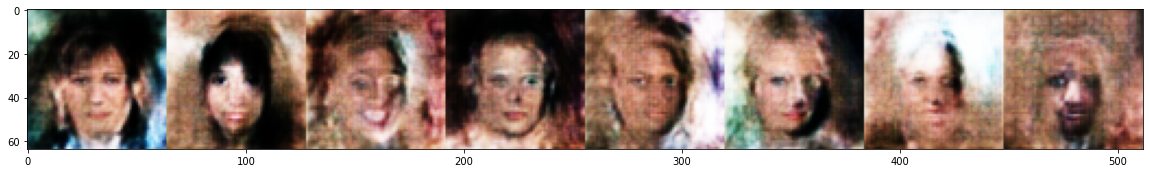

------------------------------
err_d 1.2969496250152588 err_g 3.1269381046295166
[2/10 - 0/5086] Loss_D: 1.0932 Loss_G: 1.2349   D(G(z)): 0.5145 / 0.2273 / 0.3525
[2/10 - 508/5086] Loss_D: 1.1176 Loss_G: 1.8172   D(G(z)): 0.6325 / 0.4158 / 0.1806
[2/10 - 1016/5086] Loss_D: 1.2312 Loss_G: 1.6852   D(G(z)): 0.5596 / 0.4041 / 0.2039
[2/10 - 1524/5086] Loss_D: 0.9008 Loss_G: 1.6820   D(G(z)): 0.6726 / 0.3504 / 0.2086
[2/10 - 2032/5086] Loss_D: 1.2296 Loss_G: 1.4896   D(G(z)): 0.5963 / 0.3825 / 0.2573
[2/10 - 2540/5086] Loss_D: 1.0500 Loss_G: 2.3449   D(G(z)): 0.8034 / 0.5076 / 0.1179
[2/10 - 3048/5086] Loss_D: 0.9934 Loss_G: 1.7511   D(G(z)): 0.5916 / 0.3115 / 0.2007
[2/10 - 3556/5086] Loss_D: 1.1656 Loss_G: 1.2948   D(G(z)): 0.5440 / 0.3104 / 0.3021
[2/10 - 4064/5086] Loss_D: 1.2199 Loss_G: 1.8343   D(G(z)): 0.6577 / 0.4908 / 0.1705
[2/10 - 4572/5086] Loss_D: 1.1415 Loss_G: 2.2130   D(G(z)): 0.6751 / 0.4415 / 0.1219
[2/10 - 5080/5086] Loss_D: 1.1455 Loss_G: 1.2992   D(G(z)): 0.4593 / 0.21

<Figure size 432x288 with 0 Axes>

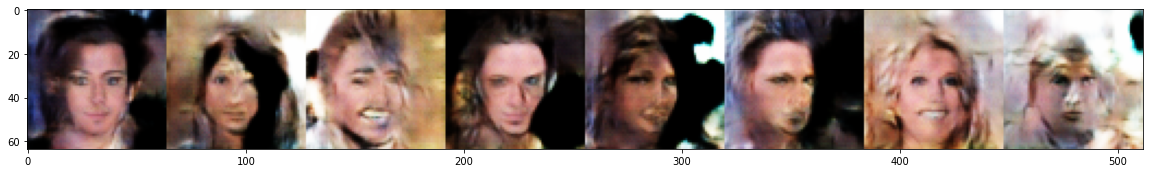

------------------------------
err_d 0.87358558177948 err_g 1.7047550678253174
[3/10 - 0/5086] Loss_D: 0.9135 Loss_G: 1.6144   D(G(z)): 0.7218 / 0.4002 / 0.2128
[3/10 - 508/5086] Loss_D: 1.1272 Loss_G: 1.7079   D(G(z)): 0.6197 / 0.4107 / 0.2133
[3/10 - 1016/5086] Loss_D: 2.2840 Loss_G: 1.7679   D(G(z)): 0.2871 / 0.0920 / 0.2723
[3/10 - 1524/5086] Loss_D: 0.8796 Loss_G: 2.4676   D(G(z)): 0.7626 / 0.3929 / 0.1143
[3/10 - 2032/5086] Loss_D: 0.3219 Loss_G: 3.7964   D(G(z)): 0.8068 / 0.0562 / 0.1159
[3/10 - 2540/5086] Loss_D: 0.5906 Loss_G: 3.1817   D(G(z)): 0.7209 / 0.1584 / 0.0661
[3/10 - 3048/5086] Loss_D: 1.2121 Loss_G: 3.2403   D(G(z)): 0.5802 / 0.3026 / 0.0626
[3/10 - 3556/5086] Loss_D: 0.6488 Loss_G: 2.4772   D(G(z)): 0.7229 / 0.2008 / 0.1152
[3/10 - 4064/5086] Loss_D: 0.8564 Loss_G: 3.5316   D(G(z)): 0.6054 / 0.0732 / 0.1000
[3/10 - 4572/5086] Loss_D: 0.6521 Loss_G: 2.8605   D(G(z)): 0.6873 / 0.1016 / 0.0941
[3/10 - 5080/5086] Loss_D: 0.7820 Loss_G: 2.6506   D(G(z)): 0.7774 / 0.3423

<Figure size 432x288 with 0 Axes>

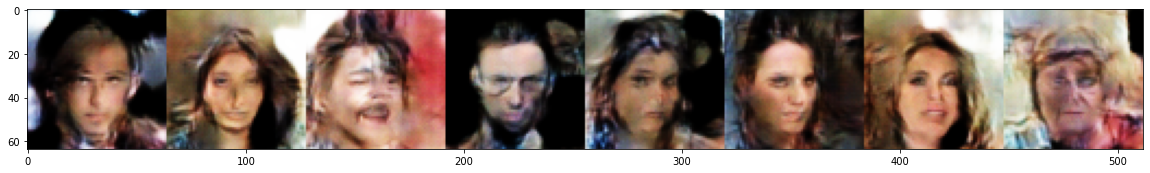

------------------------------
err_d 1.165326714515686 err_g 5.960150718688965
[4/10 - 0/5086] Loss_D: 1.3335 Loss_G: 2.2368   D(G(z)): 0.4456 / 0.1566 / 0.2072
[4/10 - 508/5086] Loss_D: 0.8087 Loss_G: 2.1906   D(G(z)): 0.6400 / 0.1567 / 0.1599
[4/10 - 1016/5086] Loss_D: 0.5114 Loss_G: 2.9060   D(G(z)): 0.8205 / 0.2173 / 0.0875
[4/10 - 1524/5086] Loss_D: 0.8037 Loss_G: 3.5901   D(G(z)): 0.8146 / 0.3351 / 0.0369
[4/10 - 2032/5086] Loss_D: 0.5154 Loss_G: 3.9091   D(G(z)): 0.8975 / 0.2539 / 0.0423
[4/10 - 2540/5086] Loss_D: 2.3354 Loss_G: 4.6080   D(G(z)): 0.9412 / 0.7495 / 0.0222
[4/10 - 3048/5086] Loss_D: 0.4791 Loss_G: 3.2530   D(G(z)): 0.7923 / 0.1297 / 0.0599
[4/10 - 3556/5086] Loss_D: 0.5014 Loss_G: 3.5236   D(G(z)): 0.7737 / 0.0813 / 0.0852
[4/10 - 4064/5086] Loss_D: 0.3646 Loss_G: 2.6336   D(G(z)): 0.8340 / 0.1120 / 0.0956
[4/10 - 4572/5086] Loss_D: 0.3491 Loss_G: 3.4146   D(G(z)): 0.8170 / 0.0684 / 0.0774
[4/10 - 5080/5086] Loss_D: 0.6976 Loss_G: 5.7658   D(G(z)): 0.9907 / 0.3794

<Figure size 432x288 with 0 Axes>

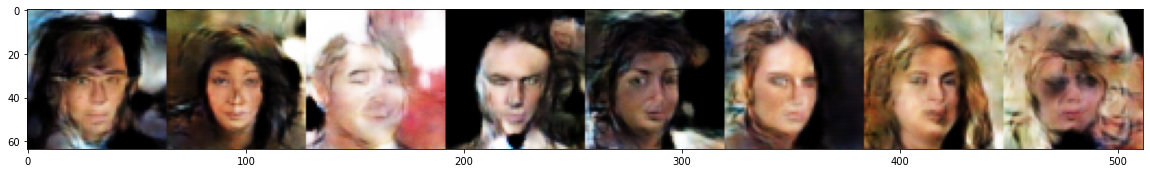

------------------------------
err_d 1.1307265758514404 err_g 2.0875930786132812
[5/10 - 0/5086] Loss_D: 0.6926 Loss_G: 4.4893   D(G(z)): 0.9343 / 0.3262 / 0.0194
[5/10 - 508/5086] Loss_D: 0.2574 Loss_G: 4.0430   D(G(z)): 0.8605 / 0.0397 / 0.0453
[5/10 - 1016/5086] Loss_D: 13.1739 Loss_G: 5.6805   D(G(z)): 0.9787 / 0.9917 / 0.1003
[5/10 - 1524/5086] Loss_D: 0.2831 Loss_G: 5.7783   D(G(z)): 0.9144 / 0.1208 / 0.0091
[5/10 - 2032/5086] Loss_D: 0.1392 Loss_G: 5.4210   D(G(z)): 0.9695 / 0.0889 / 0.0104
[5/10 - 2540/5086] Loss_D: 0.0741 Loss_G: 5.8029   D(G(z)): 0.9947 / 0.0590 / 0.0277
[5/10 - 3048/5086] Loss_D: 0.3722 Loss_G: 5.6092   D(G(z)): 0.9379 / 0.1847 / 0.0117
[5/10 - 3556/5086] Loss_D: 0.3900 Loss_G: 3.9955   D(G(z)): 0.7661 / 0.0410 / 0.0456
[5/10 - 4064/5086] Loss_D: 3.0893 Loss_G: 8.7710   D(G(z)): 0.7749 / 0.5317 / 0.0510
[5/10 - 4572/5086] Loss_D: 0.4266 Loss_G: 6.2620   D(G(z)): 0.9279 / 0.1914 / 0.0051
[5/10 - 5080/5086] Loss_D: 99.3163 Loss_G: 0.7803   D(G(z)): 0.9106 / 0.

<Figure size 432x288 with 0 Axes>

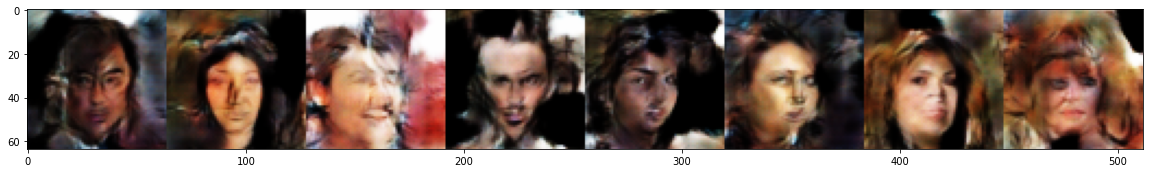

------------------------------
err_d 100.0 err_g 0.0
[6/10 - 0/5086] Loss_D: 100.0000 Loss_G: 0.0000   D(G(z)): 1.0000 / 1.0000 / 1.0000
[6/10 - 508/5086] Loss_D: 0.0546 Loss_G: 6.8836   D(G(z)): 0.9868 / 0.0367 / 0.0094
[6/10 - 1016/5086] Loss_D: 0.1809 Loss_G: 4.5763   D(G(z)): 0.9736 / 0.1081 / 0.0219
[6/10 - 1524/5086] Loss_D: 0.2137 Loss_G: 8.5198   D(G(z)): 0.8863 / 0.0108 / 0.0035
[6/10 - 2032/5086] Loss_D: 0.3239 Loss_G: 3.7678   D(G(z)): 0.8836 / 0.0915 / 0.0560
[6/10 - 2540/5086] Loss_D: 0.1109 Loss_G: 10.3856   D(G(z)): 0.9570 / 0.0250 / 0.0079
[6/10 - 3048/5086] Loss_D: 0.0215 Loss_G: 13.1764   D(G(z)): 0.9809 / 0.0002 / 0.0002
[6/10 - 3556/5086] Loss_D: 0.4101 Loss_G: 5.3995   D(G(z)): 0.9098 / 0.1118 / 0.0154
[6/10 - 4064/5086] Loss_D: 0.6063 Loss_G: 8.3407   D(G(z)): 0.7526 / 0.0010 / 0.0400
[6/10 - 4572/5086] Loss_D: 0.3104 Loss_G: 5.3683   D(G(z)): 0.9051 / 0.0838 / 0.0187
[6/10 - 5080/5086] Loss_D: 0.2510 Loss_G: 7.3583   D(G(z)): 0.9659 / 0.1008 / 0.0031


<Figure size 432x288 with 0 Axes>

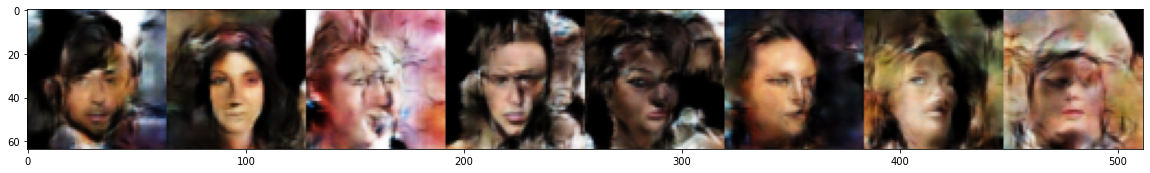

------------------------------
err_d 0.36684200167655945 err_g 6.62416934967041
[7/10 - 0/5086] Loss_D: 0.0672 Loss_G: 7.0345   D(G(z)): 0.9886 / 0.0507 / 0.0032
[7/10 - 508/5086] Loss_D: 0.3733 Loss_G: 5.9256   D(G(z)): 0.9285 / 0.1087 / 0.0056
[7/10 - 1016/5086] Loss_D: 0.1437 Loss_G: 5.8386   D(G(z)): 0.9738 / 0.0790 / 0.0083
[7/10 - 1524/5086] Loss_D: 0.2556 Loss_G: 16.6249   D(G(z)): 0.9576 / 0.1133 / 0.0016
[7/10 - 2032/5086] Loss_D: 0.0161 Loss_G: 19.4219   D(G(z)): 0.9895 / 0.0042 / 0.0052
[7/10 - 2540/5086] Loss_D: 0.4544 Loss_G: 7.0613   D(G(z)): 0.9447 / 0.1370 / 0.0055
[7/10 - 3048/5086] Loss_D: 0.3562 Loss_G: 4.7882   D(G(z)): 0.8681 / 0.0071 / 0.0480
[7/10 - 3556/5086] Loss_D: 0.1733 Loss_G: 9.2693   D(G(z)): 0.9681 / 0.0848 / 0.0038
[7/10 - 4064/5086] Loss_D: 0.1935 Loss_G: 14.5008   D(G(z)): 0.9064 / 0.0002 / 0.0005
[7/10 - 4572/5086] Loss_D: 0.0388 Loss_G: 6.4471   D(G(z)): 0.9869 / 0.0240 / 0.0066
[7/10 - 5080/5086] Loss_D: 0.6488 Loss_G: 13.8067   D(G(z)): 0.9994 / 0

<Figure size 432x288 with 0 Axes>

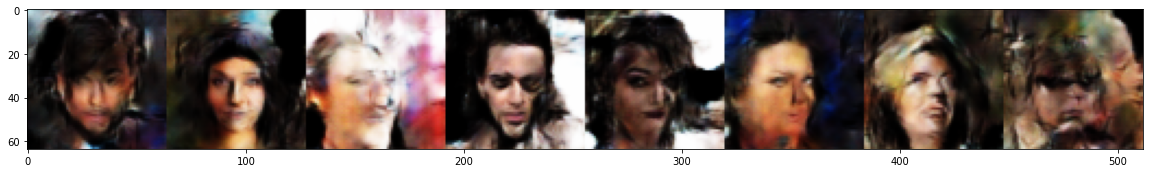

------------------------------
err_d 0.3129156529903412 err_g 9.1738862991333
[8/10 - 0/5086] Loss_D: 0.1318 Loss_G: 7.6283   D(G(z)): 0.9495 / 0.0520 / 0.0024
[8/10 - 508/5086] Loss_D: 0.3253 Loss_G: 6.3266   D(G(z)): 0.9512 / 0.1294 / 0.0065
[8/10 - 1016/5086] Loss_D: 0.1120 Loss_G: 7.1254   D(G(z)): 0.9977 / 0.0749 / 0.0044
[8/10 - 1524/5086] Loss_D: 0.4184 Loss_G: 9.3129   D(G(z)): 0.8574 / 0.0002 / 0.0009
[8/10 - 2032/5086] Loss_D: 0.3110 Loss_G: 8.8726   D(G(z)): 0.9530 / 0.0794 / 0.0008
[8/10 - 2540/5086] Loss_D: 0.0577 Loss_G: 26.0998   D(G(z)): 0.9668 / 0.0000 / 0.0000
[8/10 - 3048/5086] Loss_D: 0.1420 Loss_G: 9.1554   D(G(z)): 0.9411 / 0.0015 / 0.0017
[8/10 - 3556/5086] Loss_D: 0.1203 Loss_G: 6.7368   D(G(z)): 0.9641 / 0.0528 / 0.0069
[8/10 - 4064/5086] Loss_D: 0.1007 Loss_G: 5.8816   D(G(z)): 0.9698 / 0.0405 / 0.0083
[8/10 - 4572/5086] Loss_D: 0.0511 Loss_G: 5.9903   D(G(z)): 0.9861 / 0.0314 / 0.0082
[8/10 - 5080/5086] Loss_D: 0.3582 Loss_G: 8.7834   D(G(z)): 0.9358 / 0.0403

<Figure size 432x288 with 0 Axes>

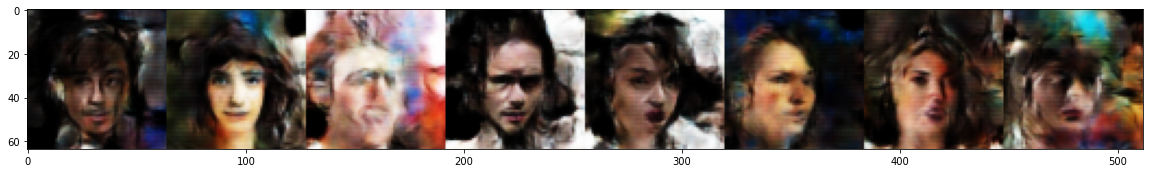

------------------------------
err_d 0.5454820990562439 err_g 7.232889175415039
[9/10 - 0/5086] Loss_D: 0.0709 Loss_G: 7.5423   D(G(z)): 0.9669 / 0.0175 / 0.0089
[9/10 - 508/5086] Loss_D: 0.0026 Loss_G: 20.4916   D(G(z)): 0.9974 / 0.0000 / 0.0000
[9/10 - 1016/5086] Loss_D: 0.0875 Loss_G: 8.1955   D(G(z)): 0.9994 / 0.0504 / 0.0030
[9/10 - 1524/5086] Loss_D: 0.0052 Loss_G: 13.0526   D(G(z)): 0.9950 / 0.0001 / 0.0001
[9/10 - 2032/5086] Loss_D: 0.0120 Loss_G: 7.8309   D(G(z)): 0.9998 / 0.0114 / 0.0193
[9/10 - 2540/5086] Loss_D: 0.4403 Loss_G: 14.3882   D(G(z)): 0.9990 / 0.2508 / 0.0000
[9/10 - 3048/5086] Loss_D: 0.0475 Loss_G: 9.7673   D(G(z)): 0.9987 / 0.0322 / 0.0015
[9/10 - 3556/5086] Loss_D: 0.2312 Loss_G: 8.5731   D(G(z)): 0.8972 / 0.0068 / 0.0232
[9/10 - 4064/5086] Loss_D: 0.0009 Loss_G: 22.5758   D(G(z)): 0.9995 / 0.0004 / 0.0004
[9/10 - 4572/5086] Loss_D: 0.3201 Loss_G: 7.4662   D(G(z)): 0.9619 / 0.0029 / 0.0056
[9/10 - 5080/5086] Loss_D: 0.0470 Loss_G: 8.7323   D(G(z)): 0.9886 / 0

<Figure size 432x288 with 0 Axes>

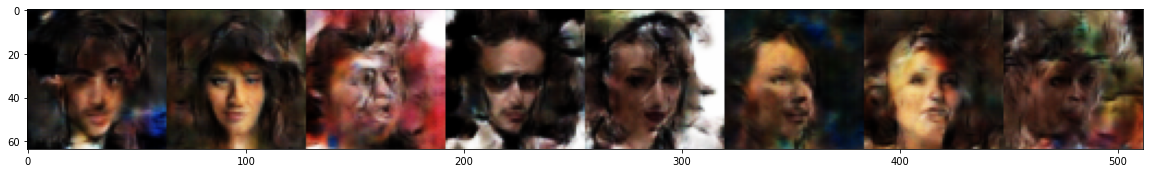

------------------------------
err_d 0.22886264324188232 err_g 7.33233118057251
[10/10 - 0/5086] Loss_D: 0.4499 Loss_G: 4.2761   D(G(z)): 0.8899 / 0.0476 / 0.0952
[10/10 - 508/5086] Loss_D: 0.0981 Loss_G: 7.5666   D(G(z)): 0.9727 / 0.0318 / 0.0038
[10/10 - 1016/5086] Loss_D: 0.0374 Loss_G: 6.9449   D(G(z)): 0.9726 / 0.0028 / 0.0131
[10/10 - 1524/5086] Loss_D: 0.3464 Loss_G: 9.5930   D(G(z)): 0.8889 / 0.0022 / 0.0012
[10/10 - 2032/5086] Loss_D: 0.4166 Loss_G: 11.5675   D(G(z)): 0.9684 / 0.0944 / 0.0002
[10/10 - 2540/5086] Loss_D: 0.0516 Loss_G: 12.6547   D(G(z)): 0.9981 / 0.0269 / 0.0004
[10/10 - 3048/5086] Loss_D: 0.2413 Loss_G: 9.2877   D(G(z)): 0.8899 / 0.0231 / 0.0018
[10/10 - 3556/5086] Loss_D: 0.1764 Loss_G: 7.1136   D(G(z)): 0.9347 / 0.0018 / 0.0079
[10/10 - 4064/5086] Loss_D: 0.3295 Loss_G: 5.0358   D(G(z)): 0.9090 / 0.0587 / 0.0407
[10/10 - 4572/5086] Loss_D: 1.0601 Loss_G: 11.3704   D(G(z)): 0.8805 / 0.0000 / 0.0272
[10/10 - 5080/5086] Loss_D: 0.0252 Loss_G: 18.8690   D(G(z)):

<Figure size 432x288 with 0 Axes>

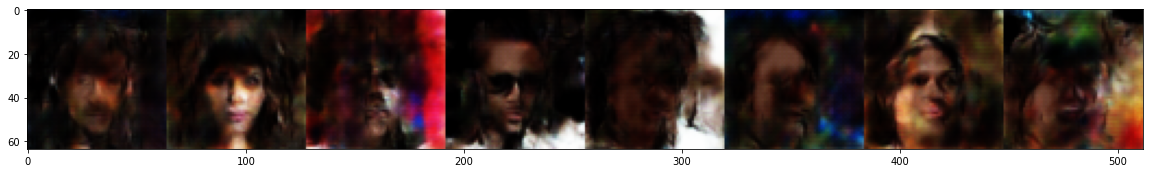

------------------------------
err_d 0.011316255666315556 err_g 12.191043853759766
avg loss d 0.011316255666315556
avg loss d 12.191043853759766
avg time 359.83293826580046 secs


<Figure size 432x288 with 0 Axes>

In [13]:
from tqdm import tqdm
import time

log_step = int(len(train_data) * 0.1)
t = time.time()
for epoch in range(start_epoch, max_epoch + 1):
    loader = enumerate(train_data)
    # loader = tqdm(loader, total=len(train_data)) # if wanna use tqdm
    d_loss_list = []
    g_loss_list = []
    for i, (imgs, _) in loader:
        loss_temp = {
            'err_d': [],
            'err_g': []
        }
        # ========== Update Discriminator ==========
        net_d.zero_grad()
        
        # throw real image into discirminator
        real_imgs = imgs.to(device)
        
        output = net_d(real_imgs)
        err_d_real = criterion(output, real_label)
        err_d_real.backward()
        d_x = output.mean().item()
        
        # throw fake image into discirminator
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = net_g(noise)
        
        output = net_d(fake_imgs.detach())
        err_d_fake = criterion(output, fake_label)
        err_d_fake.backward()
        d_g_z1 = output.mean().item()
        
        # update
        err_d = err_d_real + err_d_fake
        loss_temp['err_d'].append(err_d.item())
        optim_d.step()
        
        # ========== Update Generator ==========
        net_g.zero_grad()
        output = net_d(fake_imgs)
        err_g = criterion(output, real_label) # make generator make realer image
        loss_temp['err_g'].append(err_g.item())
        d_g_z2 = output.mean().item()
        err_g.backward()
        optim_g.step()
        
        if i % log_step == 0:
            print('[{}/{} - {}/{}] Loss_D: {:.4f} Loss_G: {:.4f}   D(G(z)): {:.4f} / {:.4f} / {:.4f}'.format(
                epoch, max_epoch, i, len(train_data),
                err_d.item(), err_g.item(), d_x, d_g_z1, d_g_z2
            ))

    fix_fake_imgs = net_g(fixed_noise).cpu().detach()
    plot_imgs(fix_fake_imgs[:8], True, file_name='out_imgs/e{:02}.png'.format(epoch))
            
    torch.save({'net_d': net_d.state_dict(), 'net_g': net_g.state_dict(),
        'epoch': epoch, 'optim_d': optim_d.state_dict(), 'optim_g': optim_g.state_dict()
    }, 'ckpts/dcgan_epoch_{:02d}.pt'.format(epoch))
    
    print('-' * 30)
    l_d = sum(loss_temp['err_d']) / len(loss_temp['err_d'])
    l_g = sum(loss_temp['err_g']) / len(loss_temp['err_g'])
    print('err_d', l_d, 'err_g', l_g)
    d_loss_list.append(l_d)
    g_loss_list.append(l_g)
print('avg loss d', sum(d_loss_list) / len(d_loss_list))
print('avg loss d', sum(g_loss_list) / len(g_loss_list))
t = time.time() - t
print('avg time', t / max_epoch, 'secs')

In [14]:
# https://github.com/AlexiaJM/Deep-learning-with-cats